In [1]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Cargamos el dataset

In [2]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Para poder replicar los resultados usaremos una semilla

In [3]:
np.random.seed(42)

Separar el data set en train y test

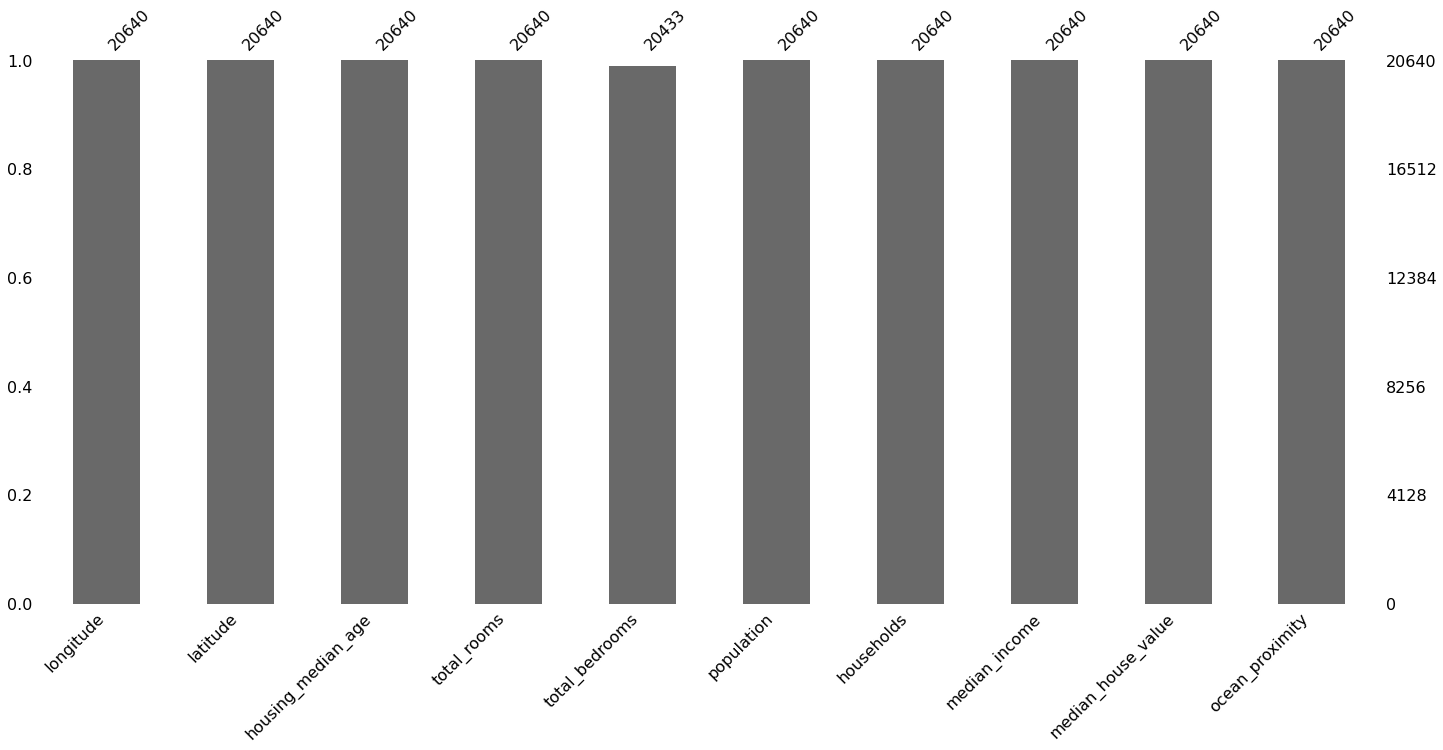

In [4]:
msno.bar(housing)

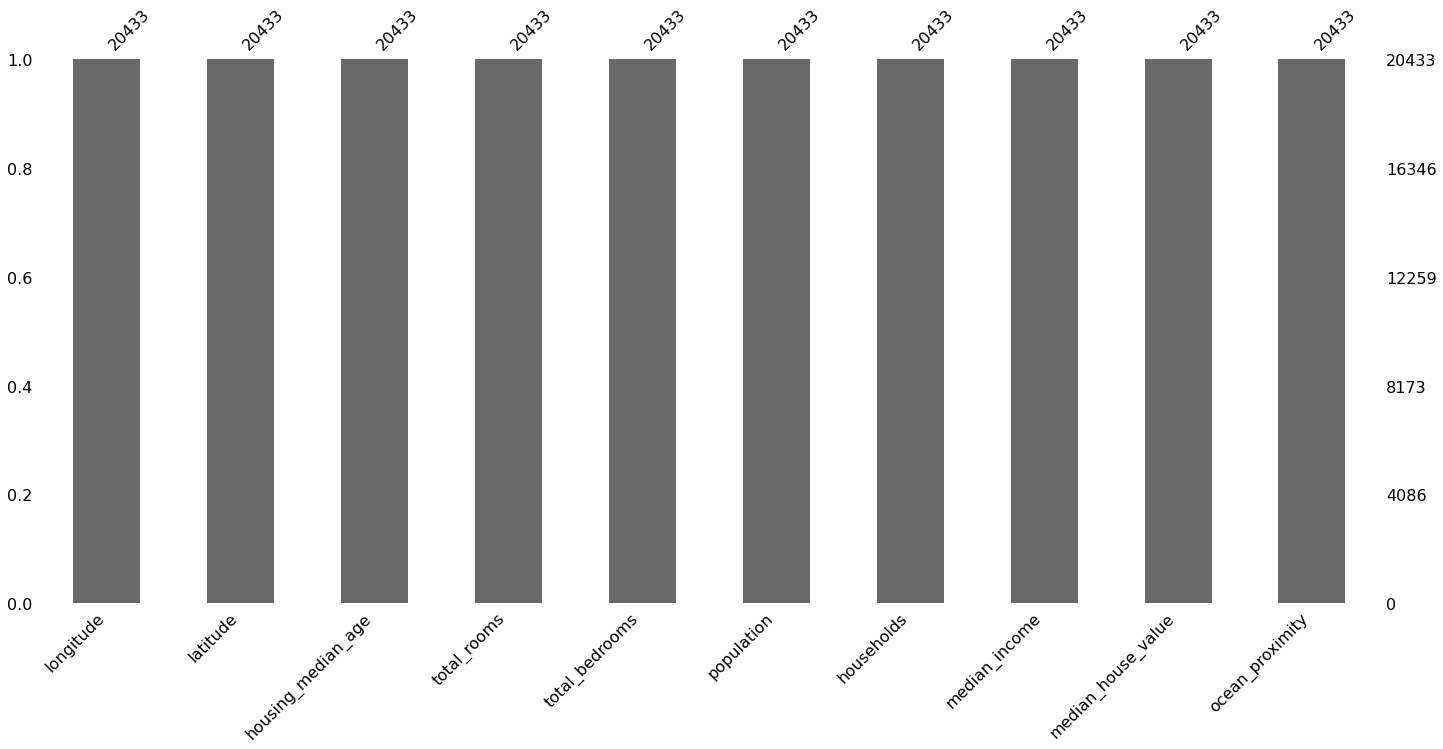

In [5]:
housing = housing.dropna()
msno.bar(housing)

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [9]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
housing = strat_train_set.copy()

C:\tools\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\tools\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\tools\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\tools\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matp

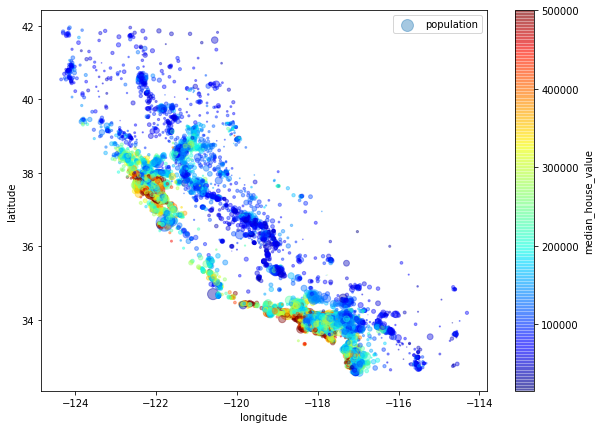

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [13]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [14]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686117
rooms_per_household         0.156488
total_rooms                 0.126363
housing_median_age          0.118640
households                  0.057231
total_bedrooms              0.041517
population_per_household   -0.026496
population                 -0.030091
longitude                  -0.050990
latitude                   -0.139508
bedrooms_per_room          -0.258508
Name: median_house_value, dtype: float64

# Preparar los datos para el modelo

In [15]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [16]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
19391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


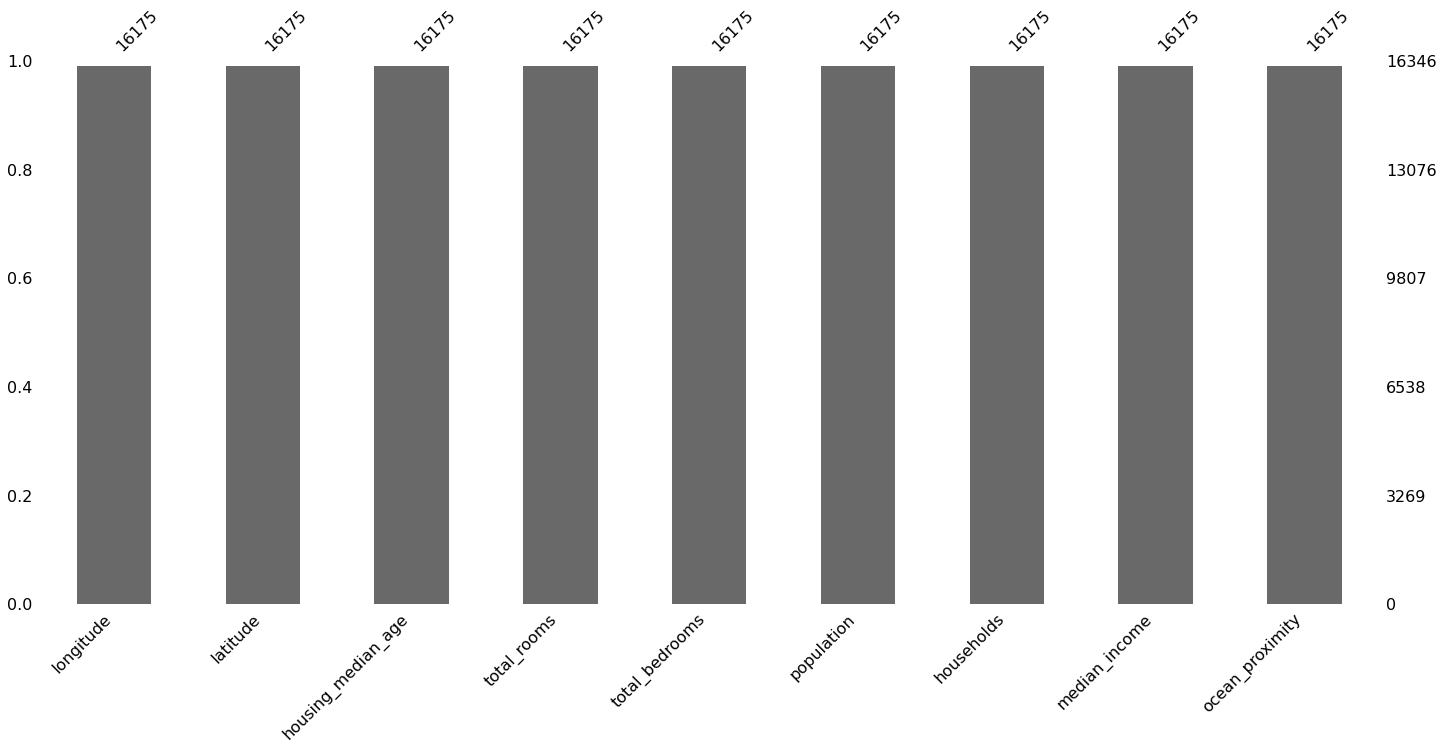

In [17]:
msno.bar(housing)

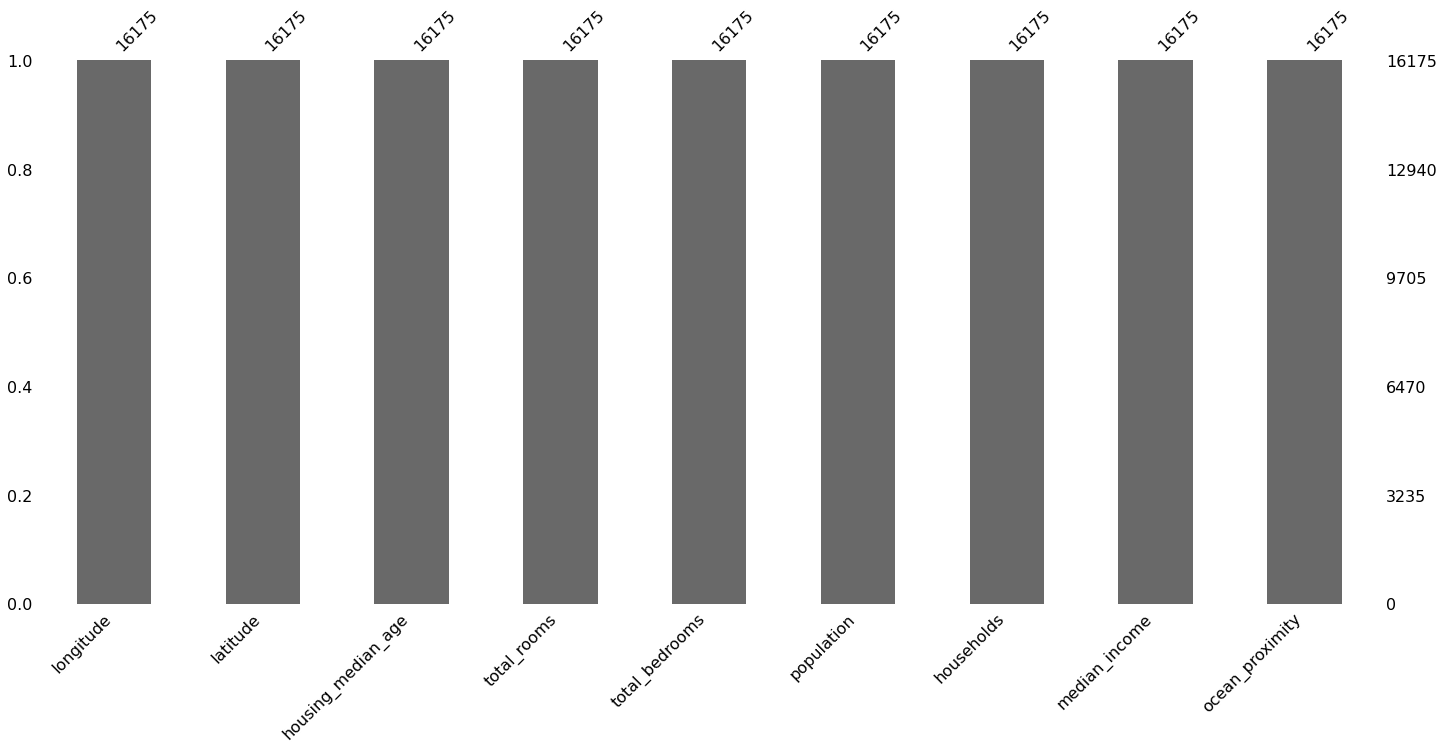

In [18]:
housing = housing.dropna()
msno.bar(housing)

In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Quitar los datos que no son numericos

In [20]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [21]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

# Transformar los datos

In [22]:
X = imputer.transform(housing_num)

In [23]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

# Procesar datos categoricos

In [24]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17880,<1H OCEAN
17389,<1H OCEAN
19010,INLAND
17641,<1H OCEAN
10162,<1H OCEAN
10422,NEAR OCEAN
8662,<1H OCEAN
195,NEAR BAY
14677,<1H OCEAN
3467,<1H OCEAN


In [25]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [26]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [27]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16175x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16175 stored elements in Compressed Sparse Row format>

In [28]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [29]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [30]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [32]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17880,-122,37.4,17,4324,854,1656,885,3.6619,<1H OCEAN,4.88588,1.87119
17389,-120.45,34.97,10,1897,354,1353,357,3.7679,<1H OCEAN,5.31373,3.78992
19010,-122,38.35,34,1084,187,561,198,4.2115,INLAND,5.47475,2.83333
17641,-121.9,37.25,28,2714,502,1389,490,5.7385,<1H OCEAN,5.53878,2.83469
10162,-117.96,33.88,25,3578,461,1588,466,6.2556,<1H OCEAN,7.67811,3.40773


# Hacer pipeline y preprocesar datos numericos

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [34]:
housing_num_tr

array([[-1.21415798,  0.83317743, -0.92259269, ..., -0.235142  ,
        -0.1088904 , -0.26327837],
       [-0.44194323, -0.30714064, -1.4767895 , ..., -0.05256021,
         0.06482595, -0.4503365 ],
       [-1.21415798,  1.27898079,  0.42331385, ...,  0.01615476,
        -0.02178034, -0.69251212],
       ...,
       [ 0.66406757, -0.77171466,  0.10662996, ..., -1.17532167,
         0.09228386,  2.77335347],
       [-0.85545177,  1.45730213, -1.79347339, ...,  0.5358438 ,
        -0.02763919, -0.92231261],
       [-1.1693197 ,  0.37329607, -1.16010561, ...,  0.37007219,
        -0.0760497 ,  0.5029048 ]])

In [35]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.21415798,  0.83317743, -0.92259269, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44194323, -0.30714064, -1.4767895 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.21415798,  1.27898079,  0.42331385, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66406757, -0.77171466,  0.10662996, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85545177,  1.45730213, -1.79347339, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1693197 ,  0.37329607, -1.16010561, ...,  0.        ,
         0.        ,  1.        ]])

# Seleccionar y entrenar el modelo

In [36]:
if(housing_prepared.shape[0] < housing_labels.shape[0]):
    housing_labels = housing_labels[0:housing_prepared.shape[0]]
else:
    housing_prepared = housing_prepared[0:housing_labels.shape[0]]
housing_prepared = np.nan_to_num(housing_prepared)
housing_labels = np.nan_to_num(housing_labels)

In [37]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [38]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [203825.70217371 203176.67813479 205753.27479283 201945.75218253
 205050.70021246]


In [40]:
print("Labels:", list(some_labels))

Labels: [232400.0, 131300.0, 118900.0, 240400.0, 341300.0]


In [41]:
some_data_prepared

array([[-1.21415798,  0.83317743, -0.92259269,  0.75702927,  0.74111783,
         0.20129039,  0.99423227, -0.11676612, -0.235142  , -0.1088904 ,
        -0.26327837,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.44194323, -0.30714064, -1.4767895 , -0.33933764, -0.43704781,
        -0.06740943, -0.3731158 , -0.0614577 , -0.05256021,  0.06482595,
        -0.4503365 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.21415798,  1.27898079,  0.42331385, -0.70660023, -0.83055513,
        -0.76975352, -0.78487403,  0.17000285,  0.01615476, -0.02178034,
        -0.69251212,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-1.16433767,  0.76278743, -0.05171198,  0.0297319 , -0.08831078,
        -0.0354847 , -0.02868911,  0.96675725,  0.04347826, -0.02165716,
        -0.47856383,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.79858239, -0.81864133, -0

In [42]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

116931.7732077936

In [43]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

92187.8814867963

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [45]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Afinar el modelo

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [47]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [172179.18741488 171005.6072584  173876.47834662 162746.56679611
 168601.26351451 170777.04687544 167351.76673896 171026.03642294
 171617.4155846  170762.69602025]
Mean: 169994.40649727243
Standard deviation: 2953.3550858446874


In [48]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [116855.88044413 117467.4169534  116493.30952235 115576.5428053
 115506.72064989 118876.9830154  117005.46323639 119845.91339728
 115738.77578255 116983.63338739]
Mean: 117035.06391940708
Standard deviation: 1339.8908783027744


In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [50]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

44694.719697442524

In [51]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [119152.9943197  119774.15712041 120288.79831126 117386.23079349
 117448.80584877 121644.67571169 119294.12633118 121826.06210398
 119440.41651713 119886.09616037]
Mean: 119614.23632179822
Standard deviation: 1398.8530802333987


In [52]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count        10.000000
mean     117035.063919
std        1412.368997
min      115506.720650
25%      115927.409217
50%      116919.756916
75%      117351.928524
max      119845.913397
dtype: float64

In [53]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

119973.93746905858

In [54]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [55]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [56]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [57]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

136054.69162931756 {'max_features': 2, 'n_estimators': 3}
124727.8311605372 {'max_features': 2, 'n_estimators': 10}
120968.76834727079 {'max_features': 2, 'n_estimators': 30}
137484.15367956788 {'max_features': 4, 'n_estimators': 3}
124531.64723941515 {'max_features': 4, 'n_estimators': 10}
121049.28592941181 {'max_features': 4, 'n_estimators': 30}
137810.56930764203 {'max_features': 6, 'n_estimators': 3}
124753.34955212813 {'max_features': 6, 'n_estimators': 10}
121149.3287465455 {'max_features': 6, 'n_estimators': 30}
137343.78071629148 {'max_features': 8, 'n_estimators': 3}
125360.89585057127 {'max_features': 8, 'n_estimators': 10}
121547.13554083911 {'max_features': 8, 'n_estimators': 30}
138165.33685831164 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
125519.63619806373 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
138667.4005907124 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
126489.52859636315 {'bootstrap': False, 'max_features': 3, 'n_es

In [58]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.257370,0.022414,0.008606,4.904270e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-1.856056e+10,-1.802956e+10,...,-1.851088e+10,3.269114e+08,12,-4.647532e+09,-4.822709e+09,-4.746314e+09,-4.710009e+09,-4.716053e+09,-4.728523e+09,5.700074e+07
1,0.371645,0.211502,0.012609,6.220727e-03,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-1.578116e+10,-1.536610e+10,...,-1.555703e+10,1.758674e+08,6,-2.728399e+09,-2.759000e+09,-2.770056e+09,-2.716207e+09,-2.709397e+09,-2.736612e+09,2.385026e+07
2,1.254631,0.636773,0.044831,2.140962e-02,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-1.483884e+10,-1.436986e+10,...,-1.463344e+10,1.860033e+08,1,-2.176384e+09,-2.196436e+09,-2.189419e+09,-2.160950e+09,-2.170345e+09,-2.178707e+09,1.280406e+07
3,0.140294,0.007578,0.003603,4.902713e-04,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-1.901551e+10,-1.881468e+10,...,-1.890189e+10,9.385585e+07,14,-4.821055e+09,-4.793006e+09,-4.960775e+09,-4.913445e+09,-4.844389e+09,-4.866534e+09,6.172063e+07
4,0.976246,0.416833,0.016412,7.843892e-03,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-1.561165e+10,-1.526805e+10,...,-1.550813e+10,2.397080e+08,5,-2.765693e+09,-2.794576e+09,-2.773473e+09,-2.801509e+09,-2.722696e+09,-2.771589e+09,2.775773e+07
5,2.296120,1.093805,0.045431,2.174554e-02,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-1.476092e+10,-1.435850e+10,...,-1.465293e+10,2.074885e+08,2,-2.186333e+09,-2.204914e+09,-2.187253e+09,-2.184165e+09,-2.163027e+09,-2.185139e+09,1.331792e+07
6,0.534754,0.075515,0.007606,2.333909e-03,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-1.916044e+10,-1.861724e+10,...,-1.899175e+10,2.787175e+08,15,-4.708034e+09,-4.823809e+09,-4.871565e+09,-4.792268e+09,-4.753221e+09,-4.789779e+09,5.634152e+07
7,1.122142,0.518744,0.016213,7.200579e-03,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-1.544271e+10,-1.538781e+10,...,-1.556340e+10,2.538834e+08,7,-2.791361e+09,-2.811165e+09,-2.775534e+09,-2.766234e+09,-2.702988e+09,-2.769457e+09,3.656435e+07
8,3.397447,1.147150,0.037826,1.715112e-02,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-1.460849e+10,-1.440900e+10,...,-1.467716e+10,2.524848e+08,3,-2.188794e+09,-2.205673e+09,-2.188516e+09,-2.186056e+09,-2.178901e+09,-2.189588e+09,8.799925e+06
9,0.246163,0.004943,0.003803,3.997091e-04,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-1.862171e+10,-1.902526e+10,...,-1.886331e+10,1.538799e+08,13,-4.734662e+09,-4.747452e+09,-4.817978e+09,-4.725091e+09,-4.848340e+09,-4.774705e+09,4.919831e+07


In [59]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [60]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

119496.7462768959 {'max_features': 7, 'n_estimators': 180}
122807.00891103648 {'max_features': 5, 'n_estimators': 15}
119648.93262905166 {'max_features': 3, 'n_estimators': 72}
121545.7391033856 {'max_features': 5, 'n_estimators': 21}
119647.09728311088 {'max_features': 7, 'n_estimators': 122}
119628.62030369259 {'max_features': 3, 'n_estimators': 75}
119513.55985439557 {'max_features': 3, 'n_estimators': 88}
119498.70713270626 {'max_features': 5, 'n_estimators': 100}
119238.06715983605 {'max_features': 3, 'n_estimators': 150}
145441.69661275376 {'max_features': 5, 'n_estimators': 2}


In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.54834041e-02, 8.50347946e-02, 7.42971957e-02, 8.99921393e-02,
       8.79351220e-02, 9.33412139e-02, 8.81276805e-02, 9.45539344e-02,
       9.35294287e-02, 9.61624547e-02, 9.31762784e-02, 5.49092746e-03,
       5.24931397e-03, 2.69030407e-05, 3.04413719e-03, 4.55507197e-03])

In [62]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.09616245465847376, 'pop_per_hhold'),
 (0.09455393444170807, 'median_income'),
 (0.09352942872529876, 'rooms_per_hhold'),
 (0.09334121393407441, 'population'),
 (0.09317627839277237, 'bedrooms_per_room'),
 (0.08999213929119014, 'total_rooms'),
 (0.088127680485532, 'households'),
 (0.08793512203637222, 'total_bedrooms'),
 (0.08548340410454928, 'longitude'),
 (0.08503479459615804, 'latitude'),
 (0.07429719570686735, 'housing_median_age'),
 (0.0054909274598977835, '<1H OCEAN'),
 (0.005249313971293484, 'INLAND'),
 (0.004555071966166677, 'NEAR OCEAN'),
 (0.0030441371889732773, 'NEAR BAY'),
 (2.6903040672479578e-05, 'ISLAND')]

In [63]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Ejercicios

# 1.
Question: Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   8.5s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   8.0s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.6s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  14.8s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  15.2s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  16.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  16.4s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  14.7s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  15.3s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=  19.0s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  16.8s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  15.7s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  15.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  15.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  14.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  14.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  16.0s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  16.2s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  16.1s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  16.0s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  15.9s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  15.8s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  17.0s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  14.8s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  17.0s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  15.3s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=  14.3s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=  16.0s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=  16.9s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=  15.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=  16.9s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 64.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [65]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

119958.28236938757

That's much worse than the RandomForestRegressor. Let's check the best hyperparameters found:

In [66]:
grid_search.best_params_

{'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}

The linear kernel seems better than the RBF kernel. Notice that the value of C is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for C (removing the smallest values), because it is likely that higher values of C will be better.

# 2

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  11.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.2s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  17.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  17.9s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  36.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  43.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  40.9s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  38.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  36.1s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=  10.3s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   9.9

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   8.5s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  27.7s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  31.6s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  26.5s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  24.5s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  26.7s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=  1

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  19.2s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  20.6s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  14.9s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  16.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  17.2s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  16.6s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  15.0s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   9.1s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   9.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=  10.3s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  15.9s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  15.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  14.3s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  17.1s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 66.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000054B059E648>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000054B059ED88>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [68]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

119959.0733010127

In [69]:
rnd_search.best_params_

{'C': 24.17508294611391, 'gamma': 3.503557475158312, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

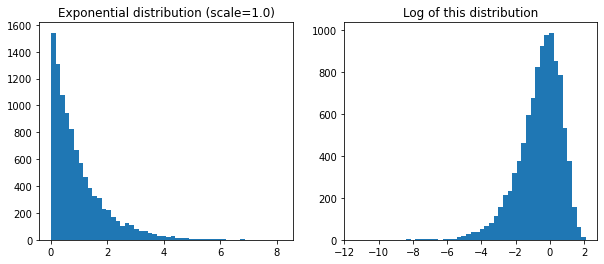

In [70]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

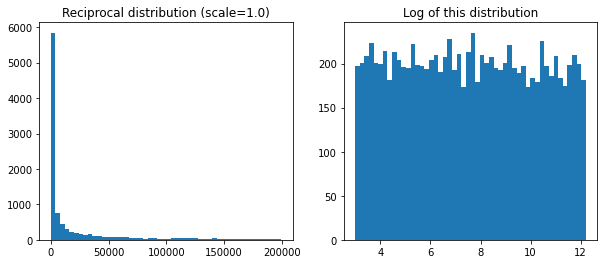

In [71]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

# 3.
Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a RandomForestRegressor). You may be tempted to compute them directly in the TopFeatureSelector's fit() method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [73]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 5,  7,  8,  9, 10], dtype=int64)

In [74]:
np.array(attributes)[top_k_feature_indices]

array(['population', 'median_income', 'rooms_per_hhold', 'pop_per_hhold',
       'bedrooms_per_room'], dtype='<U18')

In [75]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.09616245465847376, 'pop_per_hhold'),
 (0.09455393444170807, 'median_income'),
 (0.09352942872529876, 'rooms_per_hhold'),
 (0.09334121393407441, 'population'),
 (0.09317627839277237, 'bedrooms_per_room')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [76]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [77]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)


Now let's double check that these are indeed the top k features:

In [78]:
housing_prepared[0:3, top_k_feature_indices]

array([[ 0.20129039, -0.11676612, -0.235142  , -0.1088904 , -0.26327837],
       [-0.06740943, -0.0614577 , -0.05256021,  0.06482595, -0.4503365 ],
       [-0.76975352,  0.17000285,  0.01615476, -0.02178034, -0.69251212]])

# 4.
Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [79]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [80]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

Let's try the full pipeline on a few instances:

In [81]:
some_data = housing[:4]
some_labels = housing_labels[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [178290.93351019 178277.44101023 178806.29190728 177933.34684593]
Labels:		 [232400.0, 131300.0, 118900.0, 240400.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best RandomForestRegressor that we found earlier, rather than the best SVR.

# 5.
Question: Automatically explore some preparation options using GridSearchCV.

In [82]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  11.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  11.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  10.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  11.9s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  10.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  12.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  12.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  12.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  10.5s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  12.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  13.1s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  14.4s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  18.5s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  14.8s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  15.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  15.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  14.8s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  18.9s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  18.1s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  17.5s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  16.0s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  18.5s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  18.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  17.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  18.3s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  17.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  19.5s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 63.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [83]:
grid_search_prep.best_params_

{'feature_selection__k': 4, 'preparation__num__imputer__strategy': 'mean'}


The best imputer strategy is most_frequent and apparently almost all features are useful (15 out of 16). The last one (ISLAND) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)